# Single Step Prediction

Training on market prices $x_1,...,x_n$:

- Input: prices $x_1,...,x_s$, where $s = 7\cdot 24$ (1 week)
- Output: prediction for next price $x_{s+1}$

In [ ]:
import os
import torch
from torch import nn, Tensor, optim
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('../../data/time.csv')
raw_data = np.array(df['GRID (OMIE) Price (€/MWh)'].values)
scaler = MinMaxScaler()
data = scaler.fit_transform(raw_data.reshape(-1, 1)).reshape(-1)

In [ ]:
class TimeSeriesDataset(Dataset):
  def __init__(self, data: np.ndarray, seq_len: int):
    self.data = data
    self.seq_len = seq_len

  def __len__(self):
    return len(self.data) - self.seq_len

  def __getitem__(self, idx: int):
    end = idx+self.seq_len
    x = self.data[idx:end] # input: data[idx], data[idx+1], ..., data[end-1]
    y = self.data[end] # output: data[end]
    return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
  
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

SEQ_LEN = 24 # input sequence length (1 day)
train_ds = TimeSeriesDataset(train_data, SEQ_LEN)
test_ds = TimeSeriesDataset(test_data, SEQ_LEN)

train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=256, shuffle=False)

In [ ]:
class LSTMModel(nn.Module):
  def __init__(self, hidden_size = 50, num_layers = 2):
    super(LSTMModel, self).__init__()
    self.num_layers = num_layers
    self.hidden_size = hidden_size
    self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x: Tensor):
    """
    - `x`: shape (batch, seq_len)
    - output: shape (batch,)
    """
    out, _ = self.lstm(x[..., None].float().to(self.device))
    pred = out[:, -1] # last time step only
    return self.fc(pred)[:, 0]

  @property
  def device(self):
    return next(self.parameters()).device
  
def train_step(
    model: LSTMModel, x: Tensor, y: Tensor,
    *, opt: optim.Optimizer, criterion
  ) -> float:
    """
    - `x`: shape (batch, seq_len)
    - `y`: shape (batch,)
    """
    if not model.training:
      model.train()
    opt.zero_grad()
    z = model(x)
    loss: Tensor = criterion(z, y.to(model.device))
    loss.backward()
    opt.step()
    return loss.item()
  
def eval_step(
  model: LSTMModel, x: Tensor, y: Tensor,
  *, criterion
) -> float:
  """
  - `x`: shape (batch, seq_len)
  - `y`: shape (batch,)
  """
  if model.training:
    model.eval()
  with torch.no_grad():
    z = model(x)
    loss: Tensor = criterion(z, y.to(model.device))
    return loss.item()
  
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMModel().to(device)
criterion = nn.MSELoss()
opt = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
RUN_NAME = 'daily'
os.makedirs(f'checkpoints/{RUN_NAME}', exist_ok=True)

epoch_train_losses = [] 
epoch_test_losses = []

for epoch in range(250):
  n = len(train_loader)
  model.train()
  losses = []
  for i, (x, y) in enumerate(train_loader):
    print(f'\rEpoch {epoch+1} [{i+1}/{n} ({(i+1)/n:.2%})]...', end='', flush=True)
    loss = train_step(model, x, y, opt=opt, criterion=criterion)
    losses.append(loss)

  train_loss = torch.tensor(losses).mean().item()
  epoch_train_losses.append(train_loss)

  losses = []
  n = len(test_loader)
  for i, (x, y) in enumerate(test_loader):
    print(f'\rEpoch {epoch+1}, train_loss={train_loss:.6f}. Evaluating... [{i+1}/{n} ({(i+1)/n:.2%})]', end='', flush=True)
    loss = eval_step(model, x, y, criterion=criterion)
    losses.append(loss)

  test_loss = torch.tensor(losses).mean().item()
  epoch_test_losses.append(test_loss)
  print(f'\rEpoch {epoch+1}, train_loss={train_loss:.6f}, test_loss={test_loss:.6f}' + ' '*80)
  torch.save(model.state_dict(), f'checkpoints/{RUN_NAME}/{epoch+1}.pth')

In [ ]:
start = 25
plt.plot(epoch_train_losses[start:], label='train')
plt.plot(epoch_test_losses[start:], label='test')
plt.title(f'{RUN_NAME.capitalize()}: Train vs. Test Loss (starting from epoch 25)')
plt.legend()

In [ ]:
def generate(model: LSTMModel, input: Tensor, steps: int):
  """Generate `steps` predictions by feeding the model outputs as inputs in the next step.
  - `input`: initial sequence of prices, shape (seq_len,)
  - Returns: predicted prices, shape (steps,)
  """
  model.eval()
  input_seq = input.clone()
  preds = []

  for _ in range(steps):
    with torch.no_grad():
      output: Tensor = model(input_seq[None, ...]).cpu()
      preds.append(output.item())
      input_seq = torch.cat((input_seq[1:], output), 0)

  return torch.tensor(preds)


print(f'Loading {RUN_NAME}')
model.load_state_dict(torch.load(f'checkpoints/{RUN_NAME}/250.pth', weights_only=True))
model.eval()

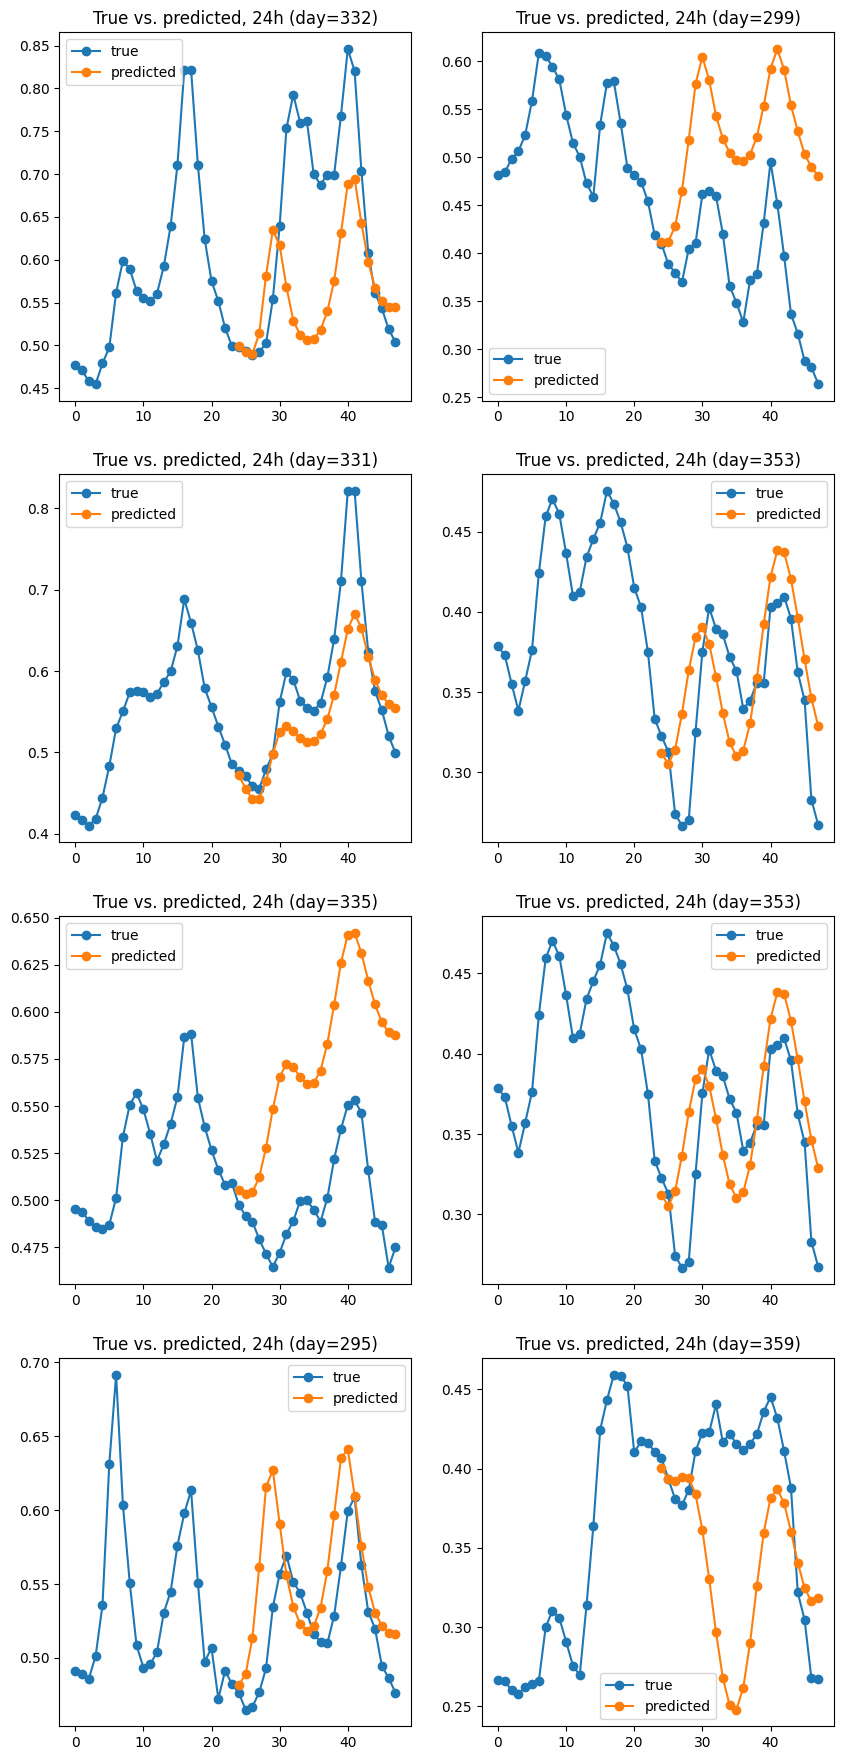

In [66]:
train_days = len(train_data)//24
test_days = len(test_data)//24
days = np.random.randint(0, test_days-1, 8)

fig, ax = plt.subplots(4, 2, figsize=(10, 22))

for i, day in enumerate(days):
  start = day*24
  input_len = 24
  pred_steps = 24
  inp = torch.tensor(test_data[start:start+input_len], dtype=torch.float32)
  preds = generate(model, inp, pred_steps)

  p: plt.Axes = ax[i//2, i%2]
  p.plot(test_data[start:start+input_len+pred_steps], '-o', label='true')
  p.plot(np.arange(input_len, input_len+pred_steps), preds, '-o', label='predicted')
  p.set_title(f'True vs. predicted, 24h (day={train_days+day})')
  p.legend()